#⌚ Wearable Data Processing and Analysis

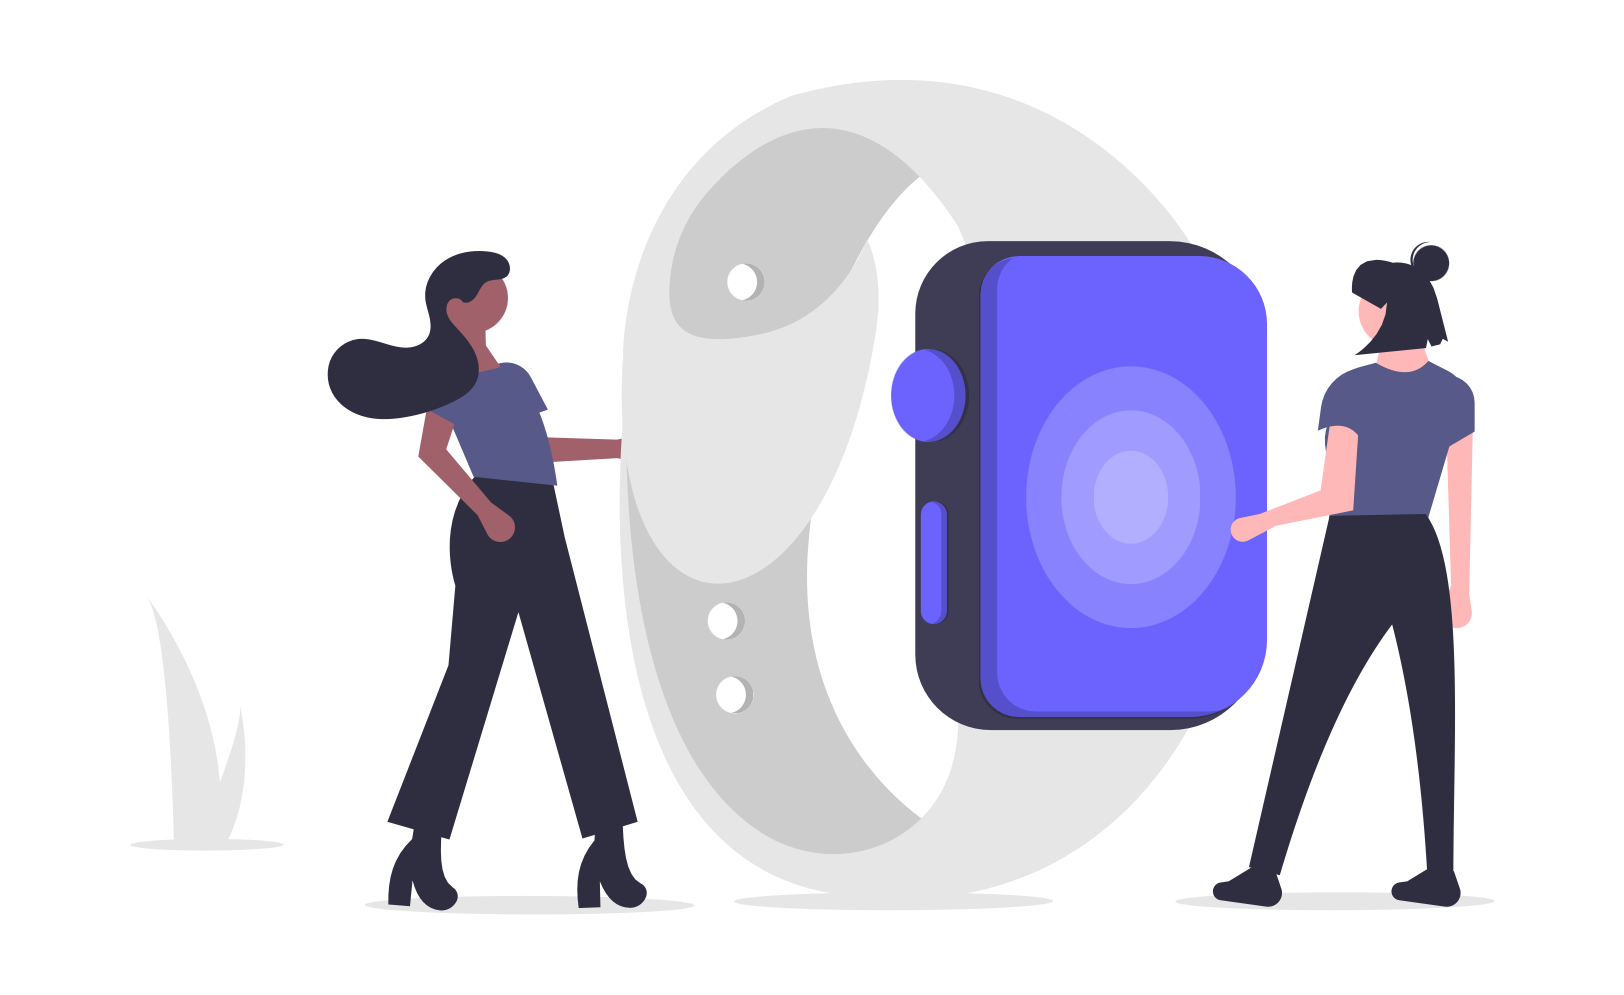


### In this notebook, you will:

1. Compare Heart Rate Variability (HRV) metrics derived from ECG
(Electroencephalograms) and PPG (Photopletsmograms)
2. Process PPG signals and calculate HRV metrics using Neurokit2
3. Train a Random Forest model to classify Hypertensive vs Normotensive people

*Neurokit2:* https://github.com/neuropsychology/NeuroKit

🗄 Please download the data to be used in this notebook here: https://figshare.com/articles/dataset/PPG_Dataset/30493520?file=59190317

**Disclaimer**: Some code snippets in this notebook were AI-generated. In such cases, they were reviewed and edited by the author when appropriate.

In [ ]:
!pip install neurokit2

In [ ]:
import os

import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.signal as sig

## 1. Compare Heart Rate Variability (HRV) metrics derived from ECG (Electroencephalograms) and PPG (Photopletsmograms)

### Load and Visualise the signals

In [ ]:
# Download example data
data = nk.data("bio_resting_5min_100hz")

In [ ]:
data["PPG"][0:300].plot() # 3 seconds of PPG data

In [ ]:
data["ECG"][0:300].plot() # 3 seconds of ECG data

### Calculate HRV Metrics

> * *SDNN* ➡ Standard Deviation of "Normal-to-Normal" heartbeat intervals => used by Apple Watch ([link](https://developer.apple.com/documentation/healthkit/hkquantitytypeidentifier/heartratevariabilitysdnn))
> * *RMSSD* ➡ Root Mean Square of Successive Differences => used by Fitbit ([link](https://support.google.com/fitbit/answer/14237938?hl=en#zippy=%2Chow-fitbit-devices-detect-heart-rate%2Cwhat-to-know-about-resting-heart-rate%2Chow-to-check-resting-heart-rate%2Cwhats-heart-rate-variability-in-the-fitbit-app))
> * 💡 **Both are usually calculated as 24-hours averages**

* Calculations: https://www.kubios.com/blog/hrv-analysis-methods/
* An Overview of Heart Rate Variability Metrics: https://pmc.ncbi.nlm.nih.gov/articles/PMC5624990/




In [ ]:
# Calculating HRV for every 5 seconds of PPG and ECG data
i = 1
start = 0
increment = 500 # 5 secs
end = increment
ppg_hrv = pd.DataFrame()
ecg_hrv = pd.DataFrame()
while i <= 30000 / increment:
  ppg = data["PPG"][start:end]
  ecg = data["ECG"][start:end]

  ppg_peaks, info_ppg = nk.ppg_peaks(ppg, sampling_rate=100)
  ppg_hrv = pd.concat([ppg_hrv, nk.hrv_time(ppg_peaks, sampling_rate=100)])

  ecg_peaks, info_ecg = nk.ecg_peaks(ecg, sampling_rate=100)
  ecg_hrv = pd.concat([ecg_hrv, nk.hrv_time(ecg_peaks, sampling_rate=100)])

  start = end + 1
  end = end + increment
  i = i + 1

ppg_hrv.reset_index(inplace=True)
ecg_hrv.reset_index(inplace=True)

In [ ]:
print(ppg_hrv[["HRV_RMSSD", "HRV_SDNN"]].shape)
ppg_hrv[["HRV_RMSSD", "HRV_SDNN"]].head()

In [ ]:
print(ecg_hrv[["HRV_RMSSD", "HRV_SDNN"]].shape)
ecg_hrv[["HRV_RMSSD", "HRV_SDNN"]].head()

### Verify Agreement Between Measurements and Devices

In [ ]:

# -----------------------------
# Function to remove outliers
# -----------------------------
def remove_outliers(series, n_std=3):
    """
    Remove outliers from a pandas Series based on ±n standard deviations from the mean.

    Parameters:
        series (pd.Series): Input data.
        n_std (float): Number of standard deviations to use as the threshold.

    Returns:
        pd.Series: Series with outliers removed (NaNs for removed values).
    """
    mean = series.mean()
    std = series.std()
    mask = (series >= mean - n_std * std) & (series <= mean + n_std * std)
    return series.where(mask)  # keeps NaN for outliers

# -----------------------------
# Function for Bland–Altman plotting
# -----------------------------
def bland_altman_plot(ax, ppg, ecg, title):
    diff = ppg - ecg  # PPG compared to ECG (reference)
    mean_values = np.mean([ppg, ecg], axis=0)

    mean_diff = np.mean(diff)
    sd_diff = np.std(diff, ddof=1)

    ax.scatter(mean_values, diff, alpha=0.6, edgecolor="k")
    ax.axhline(mean_diff, color="red", linestyle="--", label=f"Mean diff = {mean_diff:.2f}")
    ax.axhline(mean_diff + 1.96 * sd_diff, color="gray", linestyle="--", label="±1.96 SD")
    ax.axhline(mean_diff - 1.96 * sd_diff, color="gray", linestyle="--")
    ax.set_title(f"Bland–Altman: {title}")
    ax.set_xlabel("Mean of ECG and PPG")
    ax.set_ylabel("PPG − ECG")
    ax.legend()
    ax.grid(True)

# -----------------------------
# Parameters
# -----------------------------
apply_outlier_removal = True
columns_to_compare = ["HRV_RMSSD", "HRV_SDNN"]

# -----------------------------
# Clean and merge data
# -----------------------------
hrv_data = {}
for col in columns_to_compare:
    if apply_outlier_removal:
        ecg_clean = remove_outliers(ecg_hrv[col])
        ppg_clean = remove_outliers(ppg_hrv[col])
    else:
        ecg_clean = ecg_hrv[col]
        ppg_clean = ppg_hrv[col]

    combined = pd.concat([ecg_clean, ppg_clean], axis=1)
    combined.columns = ["ECG", "PPG"]
    combined.dropna(inplace=True)
    hrv_data[col] = combined
    print(f"{col} shape after cleaning: {combined.shape}")

# -----------------------------
# Plot Bland–Altman
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

bland_altman_plot(axes[0], hrv_data["HRV_RMSSD"]["PPG"].values, hrv_data["HRV_RMSSD"]["ECG"].values, "HRV_RMSSD")
bland_altman_plot(axes[1], hrv_data["HRV_SDNN"]["PPG"].values, hrv_data["HRV_SDNN"]["ECG"].values, "HRV_SDNN")

plt.tight_layout()
plt.show()

# -----------------------------
# Boxplots
# -----------------------------
data_rmssd = [hrv_data["HRV_RMSSD"]["PPG"], hrv_data["HRV_RMSSD"]["ECG"]]
data_sdnn = [hrv_data["HRV_SDNN"]["PPG"], hrv_data["HRV_SDNN"]["ECG"]]

# Create boxplots
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# HRV_RMSSD
axes[0].boxplot(data_rmssd, tick_labels=["PPG", "ECG"], patch_artist=True)
axes[0].set_title("HRV_RMSSD Comparison")
axes[0].set_ylabel("HRV_RMSSD (ms)")
axes[0].grid(True, axis="y")

# HRV_SDNN
axes[1].boxplot(data_sdnn, tick_labels=["PPG", "ECG"], patch_artist=True)
axes[1].set_title("HRV_SDNN Comparison")
axes[1].set_ylabel("HRV_SDNN (ms)")
axes[1].grid(True, axis="y")

plt.tight_layout()
plt.show()

## 2. Process PPG signals and calculate HRV metrics using Neurokit2

In [ ]:
!unzip ppg-dataset.zip -d ppg_dataset # Original dataset: https://www.nature.com/articles/sdata201820; the one provided was modified for this task

### Filter, Normalise and calculate Metrics for one PPG Signal

#### Filter and Normalise



In [ ]:
data = pd.read_csv("ppg_dataset/9_all.txt", sep="\t", header=None).transpose().dropna()
data.columns = ["PPG"]
print(data["PPG"].shape)
data["PPG"].plot() # 6 seconds of PPG data sampled at 1000 Hz

In [ ]:
# Filter the signal using a Bandppass filter
sos = sig.cheby2(4, 20, [0.5, 8], btype="bandpass", fs=1000, output="sos")
data["PPG_clean"] = sig.sosfiltfilt(sos, data["PPG"])
data["PPG_clean"].plot()

In [ ]:
# Normalise the signal
data["PPG_zscore"] = (data["PPG_clean"] - data["PPG_clean"].mean()) / data["PPG_clean"].std()
data["PPG_zscore"].plot()

#### Plot peaks, and Calculate HRV parameters


In [ ]:
# Find peaks
ppg_peaks, ppg_info = nk.ppg_peaks(data["PPG_clean"])
ppg_peaks_x = ppg_peaks["PPG_Peaks"].loc[ppg_peaks["PPG_Peaks"] == 1]

# Overlay peaks in the original signal
ppg_axes = pd.concat([ppg_peaks_x, data["PPG_clean"]], axis=1).dropna().reset_index().rename(columns={"index": "time", "PPG_clean": "y"})
ppg_axes = ppg_axes.drop(columns={"PPG_Peaks"})
ppg_peaks_axes = ppg_axes.set_index("time").rename(columns={"y": "Peaks"})
ppg_peaks_axes.plot(marker=".", markersize=12, linewidth="12", linestyle="none")
data["PPG_clean"].plot()

In [ ]:
hrv_parameters = nk.hrv_time(ppg_peaks, sampling_rate=1000)
hrv_parameters[["HRV_SDNN", "HRV_RMSSD"]]

### Extract HRV metrics from all PPG Signals

In [ ]:
# Folder containing all PPG files
folder_path = "ppg_dataset/"

# Initialize a list to store results
results = []

# Loop over all text files
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)

        # Load and preprocess
        data = pd.read_csv(file_path, sep="\t", header=None).transpose().dropna()
        data.columns = ["PPG"]

        # Bandpass filter (0.5–8 Hz)
        sos = sig.cheby2(4, 20, [0.5, 8], btype="bandpass", fs=1000, output="sos")
        data["PPG_clean"] = sig.sosfiltfilt(sos, data["PPG"])

        # Normalize signal
        data["PPG_zscore"] = (data["PPG_clean"] - data["PPG_clean"].mean()) / data["PPG_clean"].std()

        # Extract Peaks
        ppg_peaks, ppg_info = nk.ppg_peaks(data["PPG_zscore"])

        # Extract HRV metrics from peaks
        ppg_peaks = ppg_peaks["PPG_Peaks"]
        hrv_params = nk.hrv_time(ppg_peaks, sampling_rate=1000)

        # Collect HRV metrics
        sdnn = hrv_params["HRV_SDNN"].values[0]
        rmssd = hrv_params["HRV_RMSSD"].values[0]

        results.append({
            "subject_ID": filename.split("_")[0],
            "HRV_SDNN": sdnn,
            "HRV_RMSSD": rmssd
        })

# Convert results to DataFrame
hrv_summary = pd.DataFrame(results)
hrv_summary = hrv_summary.astype({
    "subject_ID": int,
    "HRV_SDNN": float,
    "HRV_RMSSD": float
})
hrv_summary

In [ ]:
print(hrv_summary.shape)

## 3. Train a Random Forest model to classify Hypertensive vs Normotensive people

### Load Population Data

In [ ]:
population_data = pd.read_csv("ppg_dataset/PPG-BP_dataset.csv")
print(population_data.shape)
population_data.head()

In [ ]:
# Calculate and display the age statistics
display(population_data['Age(year)'].describe())

# Calculate and display the percentage of people by sex
print("\nPercentage of People by Sex:")
display(population_data["Sex(M/F)"].value_counts(normalize=True) * 100)

# Calculate and display the percentage of people by hypertension status
print("\nPercentage of People by Hypertension Status:")
display(population_data["Hypertension"].value_counts(normalize=True) * 100)

# Calculate and display the percentage of people with diabetes
print("\nPercentage of People with Diabetes:")
display(population_data["Diabetes"].value_counts(normalize=True) * 100)

In [ ]:
# Set Seaborn style
sns.set(style="whitegrid", palette="pastel", context="notebook")

# Create figure with 3 rows x 2 columns
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
fig.tight_layout(pad=5.0)

# -----------------------------
# 1. Age distribution
# -----------------------------
sns.histplot(population_data["Age(year)"], bins=15, kde=True, color="skyblue", ax=axes[0,0])
axes[0,0].set_title("Age Distribution")
axes[0,0].set_xlabel("Age (years)")
axes[0,0].set_ylabel("Count")

# -----------------------------
# 2. Sex distribution
# -----------------------------
sns.countplot(x="Sex(M/F)", data=population_data, palette="Set2", hue="Sex(M/F)", legend=False, ax=axes[0,1])
axes[0,1].set_title("Sex Distribution")
axes[0,1].set_xlabel("Sex")
axes[0,1].set_ylabel("Count")

# -----------------------------
# 3. BMI distribution
# -----------------------------
sns.histplot(population_data["BMI(kg/m^2)"], bins=15, kde=True, color="lightgreen", ax=axes[1,0])
axes[1,0].set_title("BMI Distribution")
axes[1,0].set_xlabel("BMI (kg/m²)")
axes[1,0].set_ylabel("Count")

# -----------------------------
# 4. Heart Rate distribution
# -----------------------------
sns.histplot(population_data["Heart Rate(b/m)"], bins=15, kde=True, color="salmon", ax=axes[1,1])
axes[1,1].set_title("Heart Rate Distribution")
axes[1,1].set_xlabel("Heart Rate (bpm)")
axes[1,1].set_ylabel("Count")

# -----------------------------
# 5. Systolic vs Diastolic BP
# -----------------------------
sns.scatterplot(
    x="Systolic Blood Pressure(mmHg)",
    y="Diastolic Blood Pressure(mmHg)",
    hue="Sex(M/F)",
    style="Hypertension",
    palette="Set1",
    alpha=0.7,
    data=population_data,
    ax=axes[2,0]
)
axes[2,0].set_title("Systolic vs Diastolic Blood Pressure")
axes[2,0].set_xlabel("Systolic BP (mmHg)")
axes[2,0].set_ylabel("Diastolic BP (mmHg)")

# -----------------------------
# 6. Boxplot: BMI by Sex
# -----------------------------
sns.boxplot(x="Sex(M/F)", y="BMI(kg/m^2)", data=population_data, palette="Set2", hue="Sex(M/F)", legend=False, ax=axes[2,1])
axes[2,1].set_title("BMI by Sex")

plt.show()


### Add HRV Metrics to the Population Data

In [ ]:
population_data_hrv = pd.merge(population_data, hrv_summary, on="subject_ID")
print(population_data_hrv.shape)
population_data_hrv.head()

### Train and Evaluate a Random Forest Model

#### Check feature correlation

In [ ]:
# Select numeric features
numeric_features = [
    "Age(year)", "Heart Rate(b/m)", "BMI(kg/m^2)",
    "HRV_SDNN", "HRV_RMSSD"
]

# Compute correlation matrix
corr_matrix = population_data_hrv[numeric_features].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

#### Train and evaluate the model

In [ ]:
from sklearn.model_selection import (
    train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    roc_curve, auc
)
from scipy.stats import randint

# ---------------------------
# 1. Prepare data
# ---------------------------
df = population_data_hrv.copy()

def map_hypertension_label(x):
    if pd.isna(x):
        return np.nan
    s = str(x).lower()
    if "normal" in s:
        return 0
    if "pre" in s or "stage 1" in s or "stage 2" in s:
        return 1
    try:
        xi = float(x)
        if xi in (0, 1):
            return int(xi)
    except Exception:
        pass
    return np.nan

df["HT_binary"] = df["Hypertension"].apply(map_hypertension_label)

required_cols = [
    "Sex(M/F)", "Age(year)", "Heart Rate(b/m)", "BMI(kg/m^2)",
    "Diabetes", "HRV_SDNN", "HT_binary"
] # the blood pressure measurements (SBP/DBP) were not used because they are employed as diagnostic criteria for hypertension;
  # only one HRV metric was kept due to their high correlation
df_sub = df[required_cols].dropna(subset=required_cols)

print(f" Total rows after dropping NA: {len(df_sub)}")
print(df_sub["HT_binary"].value_counts())

X = df_sub.drop(columns=["HT_binary"])
y = df_sub["HT_binary"].astype(int)

numeric_cols = ["Age(year)", "Heart Rate(b/m)", "BMI(kg/m^2)", "HRV_SDNN"]
cat_cols = ["Sex(M/F)", "Diabetes"]

# ---------------------------
# 2. Preprocessing
# ---------------------------
numeric_transform = Pipeline([
    ("scaler", StandardScaler())
])
cat_transform = Pipeline([
    ("onehot", OneHotEncoder(drop="if_binary", sparse_output=False, handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transform, numeric_cols),
    ("cat", cat_transform, cat_cols)
])

# ---------------------------
# 3. Train/test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------
# 4. Random Forest + Pipeline
# ---------------------------
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced")

pipe = Pipeline([
    ("preproc", preprocessor),
    ("clf", rf)
])

# ---------------------------
# 5. Hyperparameter search
# ---------------------------
param_distributions = {
    "clf__n_estimators": randint(100, 400),
    "clf__max_depth": [3, 5, 7, 10, None],
    "clf__min_samples_split": randint(2, 10),
    "clf__min_samples_leaf": randint(1, 5),
    "clf__max_features": ["sqrt", "log2", None],
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=30,                  # try 30 random combinations
    scoring="roc_auc",          # optimize for AUC
    n_jobs=-1,
    cv=cv,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)

print("\n Best hyperparameters:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")

print(f"\nBest CV ROC AUC: {search.best_score_:.3f}")

# ---------------------------
# 6. Evaluate on test set
# ---------------------------
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\n Test set performance:")
print(classification_report(y_test, y_pred, digits=3))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR AUC : {average_precision_score(y_test, y_proba):.3f}")

# ---------------------------
# 7. ROC Curve
# ---------------------------
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--", alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Test Set")
plt.legend()
plt.grid(True)
plt.show()


#### Check feature importance

In [ ]:
# Get feature importances
clf = best_model.named_steps["clf"]

# Rebuild feature names
preproc = best_model.named_steps["preproc"]
num_names = numeric_cols
try:
    cat_names = preproc.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_cols).tolist()
except Exception:
    cat_names = preproc.named_transformers_["cat"].named_steps["onehot"].get_feature_names(cat_cols).tolist()
feature_names = num_names + cat_names

fi = clf.feature_importances_
fi_df = pd.DataFrame({"feature": feature_names, "importance": fi}).sort_values("importance", ascending=False)

# Plot top 10 features as horizontal bar chart
top_n = 10
plt.figure(figsize=(8,5))
plt.barh(fi_df["feature"].iloc[:top_n][::-1], fi_df["importance"].iloc[:top_n][::-1], color="skyblue")
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Features by Random Forest Importance")
plt.tight_layout()
plt.show()